In [2]:
import argparse
from Bio.Seq import Seq
from datasets import load_dataset
from gpn.data import Genome, load_dataset_from_file_or_dir
import grelu.resources
from grelu.sequence.format import strings_to_one_hot
import numpy as np
import os
import pandas as pd
import tempfile
import torch
import torch.nn.functional as F
from transformers import Trainer, TrainingArguments


class VEPModel(torch.nn.Module):
	def __init__(self, model, personalized_enformer=False, personalized_enformer_diff=False, shifts=[0]):
		super().__init__()
		self.model = model
		self.shifts = shifts
		self.personalized_enformer = personalized_enformer
		self.personalized_enformer_diff = personalized_enformer_diff

	def get_personalized_enformer_diff_scores(self, x_ref, x_alt):
		x_ref = x_ref.permute(0, 2, 1)
		x_alt = x_alt.permute(0, 2, 1)
		seq1 = torch.cat([x_ref.unsqueeze(1), x_ref.unsqueeze(1)], dim=1)
		seq2 = torch.cat([x_alt.unsqueeze(1), x_alt.unsqueeze(1)], dim=1)
		batch = {"seq1":seq1, "seq2":seq2}
		with torch.no_grad():
			outputs = self.model.predict_step(batch, batch_idx=0)
		return outputs["Y_diff"]

	def get_personalized_enformer_scores(self, x_ref, x_alt):
		x_ref = x_ref.permute(0, 2, 1)
		x_alt = x_alt.permute(0, 2, 1)

		outputs_ref = self.model(x_ref, 
               return_base_predictions=True,
			   base_predictions_head=None)
		outputs_alt = self.model(x_alt, 
               return_base_predictions=True,
			   base_predictions_head=None)
		y_ref = torch.cat([outputs_ref['human'], outputs_ref['mouse']], dim=2)
		assert y_ref.shape[1:] == (896, 5313 + 1643), f"y_ref.shape: {y_ref.shape}; outputs_ref['human'].shape: {outputs_ref['human'].shape}; outputs_ref['mouse'].shape: {outputs_ref['mouse'].shape}"
		y_alt = torch.cat([outputs_alt['human'], outputs_alt['mouse']], dim=2)
		assert y_alt.shape[1:] == (896, 5313 + 1643), f"y_alt.shape: {y_alt.shape}; outputs_alt['human'].shape: {outputs_alt['human'].shape}; outputs_alt['mouse'].shape: {outputs_alt['mouse'].shape}"
		lfc = torch.log2(1 + y_alt) - torch.log2(1 + y_ref) # torch.Size([bs, 896, 5313 + 1643]) for human
		l2 = torch.linalg.norm(lfc, dim=1) # [bs, 5313 + 1643]
		return l2

	def get_scores(self, x_ref, x_alt):
		y_ref = self.model(x_ref)
		y_alt = self.model(x_alt)
		lfc = torch.log2(1 + y_alt) - torch.log2(1 + y_ref) # [bs, 5313, 896]
		l2 = torch.linalg.norm(lfc, dim=2) # [bs, 5313]
		return l2

	def shift(self, x, shift_size):
		if shift_size == 0:
			return x
		
		original_shape = x.shape
		assert x.shape[1] == 4, f"x.shape: {x.shape}"

		# x is bs x 4 x seq_len torch.Size([bs, 4, 196608])
		# we want to shift x by shift_size adding padding to the left or right

		Ns = torch.zeros(x.shape[0], 4, abs(shift_size), device=x.device, dtype=x.dtype)+0.25
		assert Ns.shape == (x.shape[0], 4, abs(shift_size)), f"Ns.shape: {Ns.shape}, shift_size: {shift_size}, x.shape: {x.shape}"

		if shift_size > 0:
			#0: torch.Size([4, 4, 196608])
			# 1: torch.Size([4, 4, 196611])
			# 2: torch.Size([4, 4, 3])

			# add padding to the left
			# print ("0:",x.shape)
			x = torch.cat([Ns, x], dim=2)
			# print ("1:",x.shape)
			x = x[:,:,:-shift_size]
			# print ("2:",x.shape, shift_size)
		else:
			# add padding to the right
			# print ("0:",x.shape)
			x = torch.cat([x, Ns], dim=2)
			# print ("1:",x.shape)
			x = x[:,:,-shift_size:]
			# print ("2:",x.shape, shift_size)
		
		assert x.shape == original_shape, f"x.shape: {x.shape}, original_shape: {original_shape}, shift_size: {shift_size}"
		# AssertionError: x.shape: torch.Size([4, 2, 196610]),
		# original_shape: torch.Size([4, 4, 196608])

		assert x.shape[1] == 4, f"x.shape: {x.shape}"
		return x

	def forward(
		self,
		x_ref_fwd=None,
		x_alt_fwd=None,
		x_ref_rev=None,
		x_alt_rev=None,
	):
		if self.personalized_enformer:
			score_fn = self.get_personalized_enformer_scores
		elif self.personalized_enformer_diff:
			score_fn = self.get_personalized_enformer_diff_scores
		else:
			score_fn = self.get_scores

		scores = []
		for shift in self.shifts:
			scores.append(score_fn(self.shift(x_ref_fwd, shift), self.shift(x_alt_fwd, shift)))
			scores.append(score_fn(self.shift(x_ref_rev, shift), self.shift(x_alt_rev, shift)))

		return sum(scores)/len(scores)


def run_vep(
	variants,
	genome,
	window_size,
	model,
	per_device_batch_size=8,
	dataloader_num_workers=0,
):
	def transform(V):
		# we convert from 1-based coordinate (standard in VCF) to
		# 0-based, to use with Genome
		chrom = np.array(V["chrom"])
		n = len(chrom)
		pos = np.array(V["pos"]) - 1
		start = pos - window_size // 2
		end = pos + window_size // 2
		seq_fwd, seq_rev = zip(
			*(genome.get_seq_fwd_rev(chrom[i], start[i], end[i]) for i in range(n))
		)
		seq_fwd = np.array([list(seq.upper()) for seq in seq_fwd], dtype="object")
		seq_rev = np.array([list(seq.upper()) for seq in seq_rev], dtype="object")
		assert seq_fwd.shape[1] == window_size
		assert seq_rev.shape[1] == window_size
		ref_fwd = np.array(V["ref"])
		alt_fwd = np.array(V["alt"])
		ref_rev = np.array([str(Seq(x).reverse_complement()) for x in ref_fwd])
		alt_rev = np.array([str(Seq(x).reverse_complement()) for x in alt_fwd])
		pos_fwd = window_size // 2
		pos_rev = pos_fwd - 1 if window_size % 2 == 0 else pos_fwd

		def prepare_output(seq, pos, ref, alt):
			assert (seq[:, pos] == ref).all(), f"{seq[:, pos]}, {ref}"
			seq_ref = seq
			seq_alt = seq.copy()
			seq_alt[:, pos] = alt
			return (
				strings_to_one_hot(["".join(x) for x in seq_ref]),
				strings_to_one_hot(["".join(x) for x in seq_alt]),
			)

		res = {}
		res["x_ref_fwd"], res["x_alt_fwd"] = prepare_output(seq_fwd, pos_fwd, ref_fwd, alt_fwd)
		res["x_ref_rev"], res["x_alt_rev"] = prepare_output(seq_rev, pos_rev, ref_rev, alt_rev)
		return res

	variants.set_transform(transform)
	training_args = TrainingArguments(
		output_dir=tempfile.TemporaryDirectory().name,
		per_device_eval_batch_size=per_device_batch_size,
		dataloader_num_workers=dataloader_num_workers,
		remove_unused_columns=False,
		report_to="none",  # disables all reporting, including wandb
	)
	trainer = Trainer(model=model, args=training_args)
	return trainer.predict(test_dataset=variants).predictions

/home/jovyan/.mlspace/envs/tgymMamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/.mlspace/envs/tgymMamba/lib/python3.10/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [3]:
dataset = "complex_traits_matched_9"
if not os.path.exists(f"results/dataset/{dataset}/test.parquet"):
	os.makedirs(f"results/dataset/{dataset}", exist_ok=True)
pd.read_parquet(f"hf://datasets/songlab/TraitGym/{dataset}/test.parquet").to_parquet(f"results/dataset/{dataset}/test.parquet")

In [4]:
genome = Genome("results/genome.fa.gz")

In [5]:
variants = load_dataset_from_file_or_dir(
		f"results/dataset/{dataset}/test.parquet",
		split="test",
		is_file=True,
	)

In [6]:
# variants = variants.select(range(100))

In [90]:
# model = grelu.resources.load_model(project="enformer", model_name="human")
# instead:
# download somewhere where wandb is no blocked
# import wandb
# api = wandb.Api()
# art = api.artifact('grelu/enformer/human:latest')
# art.download("C:\\Users\\user\\Downloads\\")

# then upload to /data/ckpts/wandb_human_enformer_latest.ckpt

from grelu.lightning import LightningModel
cpt_dir = "data/ckpts/"
cpt_name = "wandb_human_enformer_latest.ckpt"
model = LightningModel.load_from_checkpoint(os.path.join(cpt_dir, cpt_name), map_location="cpu")

/home/jovyan/.mlspace/envs/tgymMamba/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v1.9.5


In [91]:
metadata_output_path = "results/metadata/Enformer.csv"
metadata = pd.DataFrame(model.data_params["tasks"])
if not os.path.exists(metadata_output_path):
	os.makedirs(os.path.dirname(metadata_output_path), exist_ok=True)
	metadata.to_csv(metadata_output_path, index=False)

In [104]:
columns = model.data_params['tasks']["name"]
window_size = model.data_params["train"]["seq_len"]
shifts = [-3,-6,0,3,6]
model_full = VEPModel(model.model, shifts=shifts)

per_device_batch_size = 4
dataloader_num_workers = 16

pred = run_vep(
	variants,
	genome,
	window_size,
	model_full,
	per_device_batch_size=per_device_batch_size,
	dataloader_num_workers=dataloader_num_workers,
)

if len(shifts)>1:
	save_model_name = f"{cpt_name}-{len(shifts)}"
else:
	save_model_name = cpt_name
output_path = f"results/dataset/{dataset}/features/{save_model_name}_L2.parquet"

directory = os.path.dirname(output_path)
if directory != "" and not os.path.exists(directory):
	os.makedirs(directory)
pd.DataFrame(pred, columns=columns).to_parquet(output_path, index=False)

KeyboardInterrupt: 

In [ ]:
# copy metadata file
metadata = pd.read_csv("results/metadata/Enformer_human.csv")
metadata.to_csv(f"results/metadata/{save_model_name}.csv", index=False)

In [38]:
pred.shape # (11400, 5313) - 11400 SNVs x 5313 enformer track predictions

(11400, 5313)

In [ ]:
# to calc stats:
# snakemake -s workflow/Snakefile --cores 4 results/dataset/complex_traits_matched_9/AUPRC_by_chrom_weighted_average/all/Enformer_L2_L2.plus.all.csv

# job                                     count
# ------------------------------------  -------
# dataset_subset_all                          1
# get_metric_by_block                         1
# get_metric_by_block_weighted_average        1
# grelu_aggregate_assay                       1
# unsupervised_pred                           1
# total                                       5


# Explore checkpoints of enformer pretrained on human variants

In [6]:
cpt = "joint_regression_data_seed_42_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3"

In [48]:
# import requests

# url = f"https://huggingface.co/anikethjr/finetuning-enformer/resolve/main/saved_models/{cpt}/checkpoints/best.ckpt?download=true"
# output_file = f"data/ckpts/{cpt}_best.ckpt"

# os.makedirs(os.path.dirname(output_file), exist_ok=True)

# with requests.get(url, stream=True) as r:
#     r.raise_for_status()
#     with open(output_file, "wb") as f:
#         for chunk in r.iter_content(chunk_size=8192):
#             if chunk:
#                 f.write(chunk)
# print(f"Downloaded checkpoint to {output_file}")

Downloaded checkpoint to data/ckpts/joint_regression_data_seed_42_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3_best.ckpt


In [10]:
cpt_dir = "data/ckpts/"
cpt_name = f"{cpt}_best.ckpt"

import sys, os
sys.path.append("../finetuning-enformer/")
from finetuning.models import PairwiseRegressionWithOriginalDataJointTrainingFloatPrecision

pers_enf_model = PairwiseRegressionWithOriginalDataJointTrainingFloatPrecision.load_from_checkpoint(
	os.path.join(cpt_dir, cpt_name)
)

/home/jovyan/.mlspace/envs/tgymMamba/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/jovyan/.mlspace/envs/tgymMamba/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/jovyan/.mlspace/envs/tgymMamba/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects 

In [109]:
# pers_enf_model

In [11]:
# use 49152 for pairwise regression, 196608 for base enformer outputs
window_size = 49152 # 196608

def get_transformed_variants(
	variants,
	genome,
	window_size,
):
	def transform(V):
		# we convert from 1-based coordinate (standard in VCF) to
		# 0-based, to use with Genome
		chrom = np.array(V["chrom"])
		n = len(chrom)
		pos = np.array(V["pos"]) - 1
		start = pos - window_size // 2
		end = pos + window_size // 2
		seq_fwd, seq_rev = zip(
			*(genome.get_seq_fwd_rev(chrom[i], start[i], end[i]) for i in range(n))
		)
		seq_fwd = np.array([list(seq.upper()) for seq in seq_fwd], dtype="object")
		seq_rev = np.array([list(seq.upper()) for seq in seq_rev], dtype="object")
		assert seq_fwd.shape[1] == window_size
		assert seq_rev.shape[1] == window_size
		ref_fwd = np.array(V["ref"])
		alt_fwd = np.array(V["alt"])
		ref_rev = np.array([str(Seq(x).reverse_complement()) for x in ref_fwd])
		alt_rev = np.array([str(Seq(x).reverse_complement()) for x in alt_fwd])
		pos_fwd = window_size // 2
		pos_rev = pos_fwd - 1 if window_size % 2 == 0 else pos_fwd

		def prepare_output(seq, pos, ref, alt):
			assert (seq[:, pos] == ref).all(), f"{seq[:, pos]}, {ref}"
			seq_ref = seq
			seq_alt = seq.copy()
			seq_alt[:, pos] = alt
			return (
				strings_to_one_hot(["".join(x) for x in seq_ref]),
				strings_to_one_hot(["".join(x) for x in seq_alt]),
			)

		res = {}
		res["x_ref_fwd"], res["x_alt_fwd"] = prepare_output(seq_fwd, pos_fwd, ref_fwd, alt_fwd)
		res["x_ref_rev"], res["x_alt_rev"] = prepare_output(seq_rev, pos_rev, ref_rev, alt_rev)
		return res

	variants.set_transform(transform)
	return variants
v = get_transformed_variants(variants.select(range(100)), genome, window_size)

In [50]:
# v[0] is a dict with keys:
# {'x_ref_fwd': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
#          [0., 1., 0.,  ..., 0., 0., 0.],
#          [0., 0., 0.,  ..., 1., 1., 0.],
#          [1., 0., 0.,  ..., 0., 0., 1.]]),
#  'x_alt_fwd': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
#          [0., 1., 0.,  ..., 0., 0., 0.],
#          [0., 0., 0.,  ..., 1., 1., 0.],
#          [1., 0., 0.,  ..., 0., 0., 1.]]),
#  'x_ref_rev': tensor([[1., 0., 0.,  ..., 0., 0., 1.],
#          [0., 1., 1.,  ..., 0., 0., 0.],
#          [0., 0., 0.,  ..., 0., 1., 0.],
#          [0., 0., 0.,  ..., 1., 0., 0.]]),
#  'x_alt_rev': tensor([[1., 0., 0.,  ..., 0., 0., 1.],
#          [0., 1., 1.,  ..., 0., 0., 0.],
#          [0., 0., 0.,  ..., 0., 1., 0.],
#          [0., 0., 0.,  ..., 1., 0., 0.]])}


In [12]:
# Move the model and input to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pers_enf_model = pers_enf_model.to(device)
input_tensor = v[0]["x_ref_fwd"].unsqueeze(0).permute(0, 2, 1).to(device)
outputs = pers_enf_model(input_tensor, 
			   return_base_predictions=True, 
			   base_predictions_head="human")
outputs.size # outputs.size

ValueError: sequence length 384 is less than target length 896

In [114]:
print ("n_total_bins:", pers_enf_model.hparams.n_total_bins)
print ("length in NT:", pers_enf_model.hparams.n_total_bins*128)
print ("center start:", pers_enf_model.center_start, "center end:", pers_enf_model.center_end)

n_total_bins: 384
length in NT: 49152
center start: 187 center end: 197


In [13]:
# Move the model and input to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pers_enf_model = pers_enf_model.to(device)
input_ref = v[0]["x_ref_fwd"].unsqueeze(0).permute(0, 2, 1).to(device)
input_alt = v[0]["x_alt_fwd"].unsqueeze(0).permute(0, 2, 1).to(device)


In [27]:
input_ref.shape

torch.Size([1, 49152, 4])

In [29]:
# seq1 is something like self.seqs[i]
# and self.seqs is             self.seqs = self.h5_file["seqs"][:]  # (n_seqs, 2, length, 4)

batch = {"seq1":torch.cat([input_ref.unsqueeze(1), input_ref.unsqueeze(1)], dim=1),
		"seq2":torch.cat([input_alt.unsqueeze(1), input_alt.unsqueeze(1)], dim=1)
		}
pers_enf_model.predict_step(batch, batch_idx=0)

# batch = {"seq1":input_ref, "seq2":input_alt}
# pers_enf_model.predict_step(batch, batch_idx=0)

{'Y1_hat': tensor([4.4787], device='cuda:0', grad_fn=<SliceBackward0>),
 'Y2_hat': tensor([4.4770], device='cuda:0', grad_fn=<SliceBackward0>),
 'Y_diff': tensor([0.0018], device='cuda:0', grad_fn=<SubBackward0>)}

In [30]:
compare_2_samples = []
compare_ref_alt = []
import tqdm
for i in tqdm.tqdm(range(20)):
	with torch.no_grad():
		inputs1 = v[i]["x_ref_fwd"].unsqueeze(0).permute(0, 2, 1).unsqueeze(0).to(device)
		inputs2 = v[i+1]["x_ref_fwd"].unsqueeze(0).permute(0, 2, 1).unsqueeze(0).to(device)
		seq1 = torch.cat([inputs1, inputs1], dim=1)
		seq2 = torch.cat([inputs2, inputs2], dim=1)
		batch = {"seq1":seq1,"seq2":seq2}
		outputs = pers_enf_model.predict_step(batch, batch_idx=0)
		compare_2_samples.append(outputs["Y_diff"].item())

		inputs1 = v[i]["x_ref_fwd"].unsqueeze(0).permute(0, 2, 1).unsqueeze(0).to(device)
		inputs2 = v[i]["x_alt_fwd"].unsqueeze(0).permute(0, 2, 1).unsqueeze(0).to(device)
		seq1 = torch.cat([inputs1, inputs1], dim=1)
		seq2 = torch.cat([inputs2, inputs2], dim=1)
		batch = {"seq1":seq1,"seq2":seq2}
		outputs = pers_enf_model.predict_step(batch, batch_idx=0)
		compare_ref_alt.append(outputs["Y_diff"].item())
		del inputs1, inputs2, seq1, seq2, batch, outputs

100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


In [33]:
print ("compare_2_samples:", np.mean(compare_2_samples), "compare_ref_alt:", np.mean(compare_ref_alt))

compare_2_samples: 0.23892528414726258 compare_ref_alt: -0.014012648165225983


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pers_enf_model = pers_enf_model.to(device)
input_tensor = v[0]["x_ref_fwd"].unsqueeze(0).permute(0, 2, 1).to(device)
outputs = pers_enf_model(input_tensor, 
			   return_base_predictions=True)
outputs # this will be a dict with keys: 'human' and 'mouse'

# Enformer base outputs (but enfromer was fine-tunned on personalized variants)

In [ ]:
window_size = 196608
per_device_batch_size = 1
dataloader_num_workers = 2

model_full = VEPModel(pers_enf_model, personalized_enformer=True)

pred = run_vep(
	variants,
	genome,
	window_size,
	model_full,
	per_device_batch_size=per_device_batch_size,
	dataloader_num_workers=dataloader_num_workers,
)

assert pred.shape[1] == 5313 + 1643, f"pred.shape: {pred.shape}"
predictions = {"human": pred[:,:5313], "mouse": pred[:,5313:]}
assert predictions["human"].shape[1] == 5313, f"human_pred.shape: {predictions['human'].shape}"
assert predictions["mouse"].shape[1] == 1643, f"mouse_pred.shape: {predictions['mouse'].shape}"

for k in ["human", "mouse"]:
	output_path = f"results/dataset/{dataset}/features/{cpt}-{k}_L2.parquet"

	directory = os.path.dirname(output_path)
	if directory != "" and not os.path.exists(directory):
		os.makedirs(directory, exist_ok=True)
	pd.DataFrame(predictions[k]).to_parquet(output_path, index=False)

In [85]:
species = "mouse"
features = pd.read_parquet(f"results/dataset/complex_traits_matched_9/features/wandb_human_enformer_latest.ckpt-{species}_L2.parquet")
metadata = pd.read_csv(f"results/metadata/Enformer_{species}.csv")
features.columns = metadata["name"].values
features.head()
features.to_parquet(f"results/dataset/complex_traits_matched_9/features/{cpt}-{species}_L2.parquet")

In [84]:
for species in ["human", "mouse"]:
	metadata_df = pd.read_csv(f"results/metadata/Enformer_{species}.csv")
	metadata_df.to_csv(f"results/metadata/{cpt}-{species}.csv", index=False)

In [79]:
!wget https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_mouse.txt -O \
	results/metadata/targets_mouse.txt

--2025-07-23 16:52:10--  https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_mouse.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250458 (245K) [text/plain]
Saving to: ‘results/metadata/targets_mouse.txt’

results/metadata/ta 100%[===================>] 244.59K  --.-KB/s    in 0.1s    

2025-07-23 16:52:10 (1.88 MB/s) - ‘results/metadata/targets_mouse.txt’ saved [250458/250458]



In [83]:
metadata = pd.read_csv("results/metadata/targets_mouse.txt", sep="\t")
metadata["assay"] = metadata["description"].apply(lambda x: x.split(":")[0])
metadata["name"] = metadata["identifier"]
metadata[["name", "assay"]].to_csv("results/metadata/Enformer_mouse.csv", index=False)

# Personalized enformer diff scores

In [ ]:
window_size = 49152
per_device_batch_size = 1
dataloader_num_workers = 8

model_full = VEPModel(pers_enf_model, personalized_enformer_diff=True)

pred = run_vep(
	variants,
	genome,
	window_size,
	model_full,
	per_device_batch_size=per_device_batch_size,
	dataloader_num_workers=dataloader_num_workers,
)
pred = pd.DataFrame(pred, columns=["all"])
output_path = f"results/dataset/{dataset}/features/{cpt}-diff_L2_L2.parquet"
pred.to_parquet(output_path, index=False)


In [10]:
pred = pd.read_parquet(f"results/dataset/complex_traits_matched_9/features/{cpt}-diff_L2_L2.parquet")

In [20]:
pred["all"] = pred["all"].abs()
pred.to_parquet(f"results/dataset/complex_traits_matched_9/features/{cpt}-diffabs_L2_L2.parquet")

In [15]:
V = pd.read_parquet("results/dataset/complex_traits_matched_9/test.parquet")
V = pd.concat([V,pred], axis=1).rename(columns={"all":"Y_diff"})

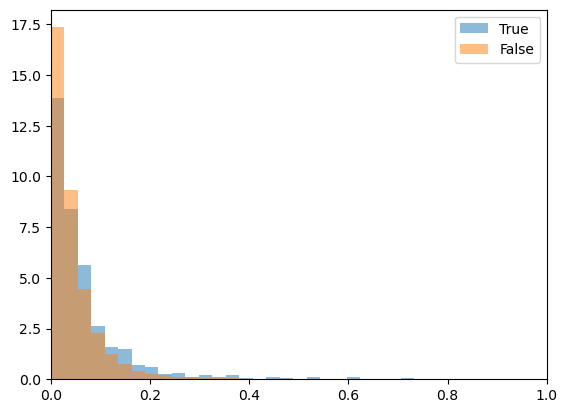

In [19]:
import matplotlib.pyplot as plt
import numpy as np
bins = np.histogram_bin_edges(V.query("label==True")["Y_diff"].abs(), bins=100)
plt.hist(V.query("label==True")["Y_diff"].abs(), bins=bins, alpha=0.5, density=True, label="True")
plt.hist(V.query("label==False")["Y_diff"].abs(), bins=bins, alpha=0.5, density=True, label="False")
plt.xlim(0, 1)
plt.legend()
plt.show()